<a href="https://colab.research.google.com/github/Kevin0368/Kevin0368/blob/main/image_class_offensive_nonoffensive_MULTIOFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. install dependencies and setup


In [ ]:
#https://www.youtube.com/watch?v=jztwpsIzEGc
#https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb

#!pip install tensorflow

In [ ]:
#!pip install tensorflow-gpu

In [ ]:
#pip install opencv-python

In [ ]:
#pip install matplotlib

In [ ]:
#!pip list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
# Check version
print(tf.__version__)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2.12.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 446820059080392052
 xla_global_id: -1]

In [ ]:
import os

In [ ]:
#avoid oom errors by setting gpu memory consumption growth
gpus = tf.config. experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

2. Remove dodgy images

In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [ ]:
data_dir ='/content/drive/MyDrive/MultiOFF_offensive_nonoffensive'

In [ ]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
  print(image_class)

offensive
Non-offensive


In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))
      # os.remove(image_path)

3. Load data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#can alter image size, batch size etc here
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/MultiOFF_offensive_nonoffensive')

Found 601 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
# get another batch from the iterator
batch = data_iterator.next()

In [ ]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [ ]:
# image labels
# class 1 = nonoffensive (nohate)
# class 0 = offensive (hate)
batch[1]

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1], dtype=int32)

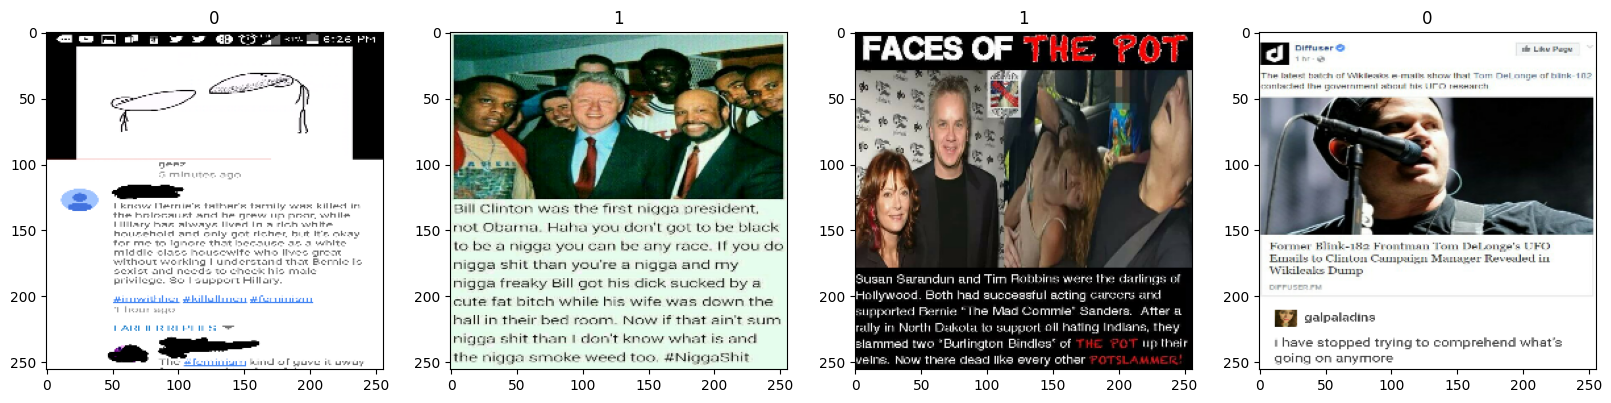

In [ ]:
fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

4. Scale Data (preprocess)

In [ ]:
scaled = batch[0]/255

In [ ]:
scaled.max()

1.0

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

5. split data

In [ ]:
#length of data batches
len(data)

19

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)+1
test_size = int(len(data)*.1)+3

In [ ]:
train_size+val_size+test_size

19

In [ ]:
#using the train and skip method from tensorflow

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
#length of train batches to be allocated
print(len(train))
print(len(val))
print(len(test))

13
2
4


6. Build deep learning model

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [ ]:
#model = Sequential()

In [ ]:
#architectural decisions for model
#relu activation
#sigmoid activation

model = Sequential()
def img_model(model):
  model.add(Conv2D(16,(3,3), 1, activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D())
  model.add(Conv2D(32,(3,3), 1, activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(16,(3,3), 1, activation='relu'))
  model.add(MaxPooling2D())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  return model

img_model(model)

#conv 2d for img
#concatenate the dense layer with text dense layer
#use different name for model in text to avoid confusion

In [ ]:
#using adam optimiser
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

7. Train

In [ ]:
logdir ='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/2
13/13 [==============================] - 47s 3s/step - loss: 0.6512 - accuracy: 0.6538 - val_loss: 0.6518 - val_accuracy: 0.5938
Epoch 2/2
13/13 [==============================] - 41s 3s/step - loss: 0.6044 - accuracy: 0.6683 - val_loss: 0.5592 - val_accuracy: 0.7344


8. Plot performance

<function matplotlib.pyplot.show(close=None, block=None)>

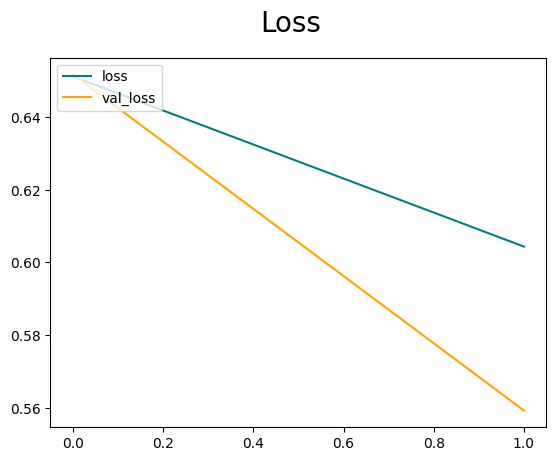

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show

#if losses do not decrease, data may need to be regularised or there might be overfitting

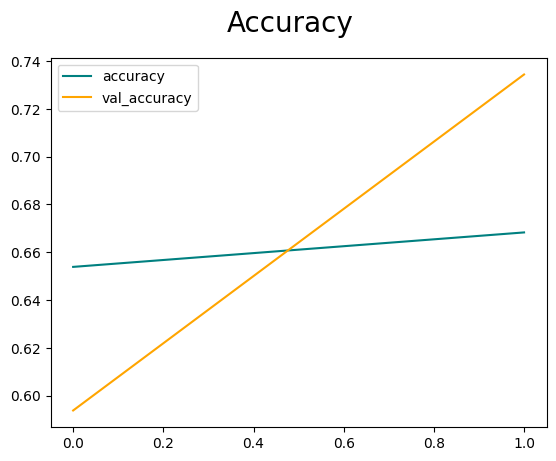

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
lbls = []
lblp = []

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

  print('y ', type(y), y.tolist())

  lbls.append(y.tolist())

  for i in yhat:
    lblp.append(i[0])

1/1 [==============================] - 1s 598ms/step
y  <class 'numpy.ndarray'> [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
1/1 [==============================] - 0s 500ms/step
y  <class 'numpy.ndarray'> [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
1/1 [==============================] - 1s 514ms/step
y  <class 'numpy.ndarray'> [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]
1/1 [==============================] - 0s 437ms/step
y  <class 'numpy.ndarray'> [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]
lbls  [[1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1], [0, 1, 1, 1,

In [ ]:
print('lbls ',lbls)

print('lblp ', lblp)

In [ ]:
#roundup predicted labels
lblp = [round(lblp) for lblp in lblp]

print(lbls)

#flatten test labels
lbls = [item for sublist in lbls for item in sublist]


In [ ]:
print(lbls)
print(lblp)

print('length of lbls is', len(lbls))
print('length of lblp is', len(lblp))

In [ ]:
#https://machinelearningmastery.com/confusion-matrix-machine-learning/
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

!pip install 'matplotlib<3.3.0'

import matplotlib.pyplot as plt

y_true = lbls # this should be your actual labels that are from the dataset

y_pred = lblp # this should be the predicted labels by the model

confusion_matrix = confusion_matrix(y_true, y_pred, normalize= 'true') # you pass the actual labels and the predicted ones to the confusion matrix

# you cannot use the following line because you are not using dataframe, This code comes from your other code that is not applicable to this one
#target_labels = df['class'].unique # this is the set of unique labels
# (should be unique values from class column)

# the line below
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_true)

disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy}')

Precision:0.7749999761581421, Recall:0.6595744490623474, Accuracy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.7933884>>


In [ ]:
Precision = pre.result().numpy()
print(Precision)
Recall = re.result().numpy()
print(Recall)

0.775
0.65957445


In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score
f1_score = (Precision * Recall / (Precision + Recall)) * 2
f1_score

0.7126437425613403

10. Test

In [ ]:
import cv2

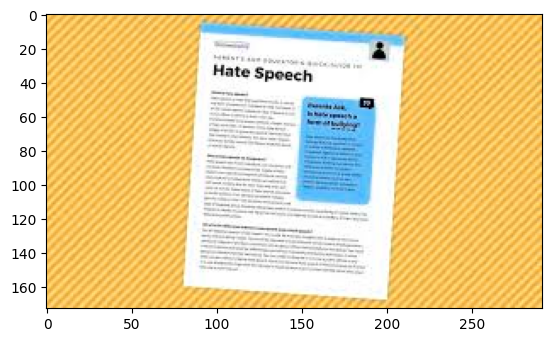

In [ ]:
img = cv2.imread('/content/drive/MyDrive/hate_nonhate_images_google/hate/images100.jpg')
plt.imshow(img)
plt.show()

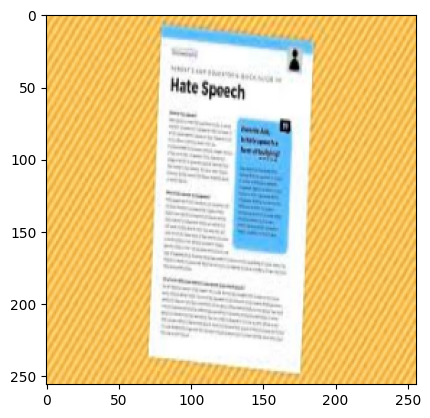

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 40ms/step


In [ ]:
yhat

array([[0.47111496]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Hate')
else:
    print(f'Predicted class is nonHate')

Predicted class is nonHate


11. Save model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/models','imageclassifier.h5'))

In [ ]:
new_model = load_model('/content/drive/MyDrive/models/imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 100ms/step


array([[0.47111496]], dtype=float32)